# Comparing mutational effects among Env homologs

## Overview
This Jupyter notebook compares the effects of mutations between two homologs of HIV Env, the BG505 and BF520 strains.
The goal is to quantify how much the effects of mutations have shifted between the viral strains.

This analysis was done by Hugh Haddox, Adam Dingens, Sarah Hilton, and Jesse Bloom.

## Import modules and define common paths
First we import Python modules used throughout the notebook, and define key directory paths.

In [1]:
import os
import string
import itertools
import multiprocessing
import glob
import pandas
import Bio.SeqIO
import Bio.Seq
import Bio.SeqRecord
import Bio.Phylo
import matplotlib
import matplotlib.pyplot as plt
import seaborn
from IPython.display import display, HTML
import dms_tools2
print("Using dms_tools2 version {0}".format(dms_tools2.__version__))
from dms_tools2.ipython_utils import showPDF
import dms_tools2.sra
import dms_tools2.utils
import phydmslib
print("Using phydms version {0}".format(phydmslib.__version__))

# define directories in which results are placed
resultsdir = './results/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# do we use existing program output if already present?
use_existing = 'yes'

# Use up to 15 CPUs, more uses too much memory for Hutch server
ncpus = min(15, multiprocessing.cpu_count())

Using dms_tools2 version 2.2.dev0
Using phydms version 2.1.4


## Env sequences and numbering
A major complexity is how to number and align the two Env homologs.
For computational purposes, it is often convenient to number the sequences sequentially as 1, 2, ... beginning with the N-terminal methionine.
However, the standard numbering scheme for HIV Env is the [HXB2 numbering scheme](https://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).
In this notebook, we process the FASTQ files and count the mutations in sequential numbering, and then map these numbers to the [HXB2 numbering scheme](https://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html) for all subsequent steps.

In addition, we need to align the Env homologs, and take into account that we only mutagenized a portion of Env (we excluded the N-terminal signal peptide and the C-terminal cytoplasmic tail).

First, we define the files holding the Env coding sequences (these are [./data/BG505_env.fasta](./data/BG505_env.fasta) and [./data/BF520_env.fasta](./data/BF520_env.fasta)) as well as the regions of these sequences that were mutagenized in sequential 1, 2, ... numbering.

In [2]:
# the homologs that we are examining
homologs = ['BG505', 'BF520']

# files with codon sequences
wtseqfiles = dict([(env, './data/{0}_env.fasta'.format(env)) for env in homologs])

# the mutagenized codon sites in 1, 2, ... numbering
# for both this is 31-702 in HXB2 numbering
mutagenizedsites = {
        'BG505':list(range(30, 699 + 1)),
        'BF520':list(range(30, 691 + 1))
        }

Now we read in the aligned sequences of the Env homologs and HXB2.
This alignment was created with [mafft](https://mafft.cbrc.jp/alignment/software/) and then manually edited by Hugh Haddox in some of the variable loop regions that align very poorly.
The manually edited alignment is in [./data/Env_protalignment_manualtweaks.fasta](./data/Env_protalignment_manualtweaks.fasta).

After reading in the aligned proteins from file, we compute the pairwise identity of the two sequences over all non-gapped **mutagenized** sites (we do not include the sites not mutagenized in this calculation):

In [3]:
protalignmentfile = './data/Env_protalignment_manualtweaks.fasta'
alignedprots = dict([(seq.name, str(seq.seq)) for seq in 
        Bio.SeqIO.parse(protalignmentfile, 'fasta')])

for (env1, env2) in itertools.combinations(homologs, 2):
    (s1, s2) = (alignedprots[env1], alignedprots[env2])
    sites = [r for r in range(len(s1)) if s1[r] != '-' and s2[r] != '-']
    nident = sum([s1[r] == s2[r] for r in sites])
    print("The {0} and {1} proteins are {2:.3f} identical ({3} of {4} alignable sites)"
            .format(env1, env2, nident / float(len(sites)), nident, len(sites)))

The BG505 and BF520 proteins are 0.862 identical (732 of 849 alignable sites)


Now we create files that map each residue in our Env homologs to comparable residue sequential numbering of HXB2.
This creates a mapping to the [HXB2 numbering scheme](https://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html) that we will use later.
The renumbering files have columns named *original* (sequential 1, 2, ... numbering) and *new* (HXB2 numbering).

In [4]:
renumbdir = os.path.join(resultsdir, 'HXB2_numbering')
if not os.path.isdir(renumbdir):
    os.mkdir(renumbdir)

# keyed by homolog, value is renumbering file
renumbfile = {}
    
for env in homologs:
    
    # first build numbering with HXB2 numbers potentially repeated
    hxb2_r = 1
    hxb2_nums = [] # holds HXB2 numbers
    for (hxb2_aa, aa) in zip(alignedprots['HXB2'], alignedprots[env]):
        if aa != '-':
            hxb2_nums.append(str(hxb2_r - int(hxb2_aa == '-')))
        if hxb2_aa != '-':
            hxb2_r += 1
            
    # now take all runs of HXB2 numbers and make them 10, 10a, 10b, etc...
    for num in set(hxb2_nums):
        n_num = hxb2_nums.count(num)
        firstnum = hxb2_nums.index(num)
        for i in range(n_num - 1):
            hxb2_nums[firstnum + i + 1] = num + string.ascii_lowercase[i]
                
    # now write renumbering file
    renumbfile[env] = os.path.join(renumbdir, '{0}_to_HXB2.csv'.format(env))
    print("Writing HXB2 renumbering file for {0} to {1}".format(
            env, renumbfile[env]))
    with open(renumbfile[env], 'w') as f:
        f.write('original,new\n')
        for (r, new) in enumerate(hxb2_nums):
            f.write('{0},{1}\n'.format(r + 1, new))      

Writing HXB2 renumbering file for BG505 to ./results/HXB2_numbering/BG505_to_HXB2.csv
Writing HXB2 renumbering file for BF520 to ./results/HXB2_numbering/BF520_to_HXB2.csv


## Download deep sequencing data from the Sequence Read Archive
The deep sequencing reads have been submitted to the [Sequence Read Archive (SRA)](http://www.ncbi.nlm.nih.gov/sra), so we download them from there:
* The BF520 reads have the BioSample Accession number [SAMN06313000](https://www.ncbi.nlm.nih.gov/sra?term=SAMN06313000) and BioProject number [PRJNA371844](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA371844/).
* The BG505 reads have the BioSample Accession number [SAMN07718028](https://www.ncbi.nlm.nih.gov/sra?term=SAMN07718028) and BioProject number [PRJNA412552](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA412552/).

We download these files using the [dms_tools2.sra.fastqFromSRA](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html#dms_tools2.sra.fastqFromSRA) function from the [dms_tools2 Python API](https://jbloomlab.github.io/dms_tools2/api.html). Note that the call to this function below uses two external programs that you must ensure are installed on the computer that you are using:

1. The [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) program from the [SRA Toolkit](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc). If you do not already have this toolkit installed, you will need to install it by following [these instructions](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=std). You need a relatively recent version.

2. The [Aspera Connect program](https://www.ncbi.nlm.nih.gov/books/NBK242625/) for rapid downloads. You need both the executable `ascp` and an Aspera Key file. Installing Aspera Connect and a key can be somewhat complex, so if you do not want to do this then just set `aspera=None` in the command below and `fastq-dump` will do the downloads (albeit more slowly).

For each homolog, there are the following samples:
* the wildtype plasmid controls (*DNA*)
* the mutant plasmid DNA libraries (*mutDNA*)
* the wildtype virus controls (*virus*)
* the mutant virus samples (*mutvirus*)

There are three replicates of all of these samples for each homolog, except that the BF520 homolog only has one *DNA* control.

In [5]:
# specify names of all samples to download
samples = pandas.DataFrame.from_records(
        [('BF520', 'DNA', 'SRR5241717'),
         ('BF520', 'mutDNA-1', 'SRR5241726'),
         ('BF520', 'mutDNA-2', 'SRR5241725'),
         ('BF520', 'mutDNA-3', 'SRR5241724'),
         ('BF520', 'virus-1', 'SRR5241716'),
         ('BF520', 'virus-2', 'SRR5241715'),
         ('BF520', 'virus-3', 'SRR5241714'),
         ('BF520', 'mutvirus-1', 'SRR5241723'),
         ('BF520', 'mutvirus-2', 'SRR5241721'),
         ('BF520', 'mutvirus-3', 'SRR5241719'),
         ('BG505', 'DNA-1', 'SRR6117033'),
         ('BG505', 'DNA-2', 'SRR6117029'),
         ('BG505', 'DNA-3', 'SRR6117027'),
         ('BG505', 'mutDNA-1', 'SRR6117032'),
         ('BG505', 'mutDNA-2', 'SRR6117028'),
         ('BG505', 'mutDNA-3', 'SRR6117026'),
         ('BG505', 'virus-1', 'SRR6117034'),
         ('BG505', 'virus-2', 'SRR6117030'),
         ('BG505', 'virus-3', 'SRR6117024'),
         ('BG505', 'mutvirus-1', 'SRR6117035'),
         ('BG505', 'mutvirus-2', 'SRR6117031'),
         ('BG505', 'mutvirus-3', 'SRR6117025')
        ],
        columns=['homolog', 'sample_name', 'run']
        )
samples['name'] = samples['homolog'] + '-' + samples['sample_name']

# download to this directory
fastqdir = os.path.join(resultsdir, 'FASTQ_files/')

print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

Here are the names of the downloaded files now found in ./results/FASTQ_files/


homolog,sample_name,run,name,R1,R2
BF520,DNA,SRR5241717,BF520-DNA,BF520-DNA_R1.fastq.gz,BF520-DNA_R2.fastq.gz
BF520,mutDNA-1,SRR5241726,BF520-mutDNA-1,BF520-mutDNA-1_R1.fastq.gz,BF520-mutDNA-1_R2.fastq.gz
BF520,mutDNA-2,SRR5241725,BF520-mutDNA-2,BF520-mutDNA-2_R1.fastq.gz,BF520-mutDNA-2_R2.fastq.gz
BF520,mutDNA-3,SRR5241724,BF520-mutDNA-3,BF520-mutDNA-3_R1.fastq.gz,BF520-mutDNA-3_R2.fastq.gz
BF520,virus-1,SRR5241716,BF520-virus-1,BF520-virus-1_R1.fastq.gz,BF520-virus-1_R2.fastq.gz
BF520,virus-2,SRR5241715,BF520-virus-2,BF520-virus-2_R1.fastq.gz,BF520-virus-2_R2.fastq.gz
BF520,virus-3,SRR5241714,BF520-virus-3,BF520-virus-3_R1.fastq.gz,BF520-virus-3_R2.fastq.gz
BF520,mutvirus-1,SRR5241723,BF520-mutvirus-1,BF520-mutvirus-1_R1.fastq.gz,BF520-mutvirus-1_R2.fastq.gz
BF520,mutvirus-2,SRR5241721,BF520-mutvirus-2,BF520-mutvirus-2_R1.fastq.gz,BF520-mutvirus-2_R2.fastq.gz
BF520,mutvirus-3,SRR5241719,BF520-mutvirus-3,BF520-mutvirus-3_R1.fastq.gz,BF520-mutvirus-3_R2.fastq.gz


## Align deep sequencing reads and count mutations
We used [barcoded-subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to deep sequence the above samples. 
So we need to align the reads to count mutations.

### Barcoded-subamplicon alignment
We use [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) to process the FASTQ files to counts of each mutant codon at each site.
Note that we create a site mask so that the alignments are only done for the mutagenized sites.

In [6]:
# alignment specs for each homolog
alignspecs = {
        'BG505':' '.join(
                   ['87,375,39,36',
                    '376,666,36,39',
                    '663,954,33,41',
                    '955,1228,33,37',
                    '1228,1527,34,35',
                    '1527,1815,32,39',
                    '1816,2098,36,41']),
        'BF520':' '.join(
                   ['88,417,40,39', 
                    '418,753,39,35',
                    '754,1092,36,39',
                    '1093,1447,35,29',
                    '1407,1758,35,32',
                    '1759,2097,30,36'])
        }

# read trimming for each homolog
r1trim = {'BG505':'200', 'BF520':'205'}
r2trim = {'BG505':'170', 'BF520':'212'}

# define counts directory containing output for each homolog
basecountsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(basecountsdir):
    os.mkdir(basecountsdir)
countsdir = {}
for env in homologs:
    countsdir[env] = os.path.join(basecountsdir, env)
    if not os.path.isdir(countsdir[env]):
        os.mkdir(countsdir[env])

# align each homolog
for env in homologs:
    print('\nAligning reads and counting mutations for {0}, '
          'placing results in {1}'.format(env, countsdir[env]))
    
    countsbatchfile = os.path.join(countsdir[env], 'batch.csv')
    print("Here is the batch file that we use as input:")
    countsbatch = (samples.query('homolog == @env')
                          [['sample_name', 'R1']]
                          .rename(columns={'sample_name':'name'})
                          )
    display(HTML(countsbatch.to_html(index=False)))
    countsbatch.to_csv(countsbatchfile, index=False)
    
    # make a sitemask that includes only mutagenized sites
    sitemask = os.path.join(countsdir[env], 'sitemask.csv')
    with open(sitemask, 'w') as f:
        f.write('\n'.join(map(str, ['site'] + mutagenizedsites[env])))

    print('\nNow running dms2_batch_bcsubamp...')
    log = !dms2_batch_bcsubamp \
            --batchfile {countsbatchfile} \
            --refseq {wtseqfiles[env]} \
            --alignspecs {alignspecs[env]} \
            --outdir {countsdir[env]} \
            --summaryprefix summary \
            --R1trim {r1trim[env]} \
            --R2trim {r2trim[env]} \
            --fastqdir {fastqdir} \
            --ncpus {ncpus} \
            --sitemask {sitemask} \
            --use_existing {use_existing} 
    print("Completed dms2_batch_bcsubamp.")


Aligning reads and counting mutations for BG505, placing results in ./results/codoncounts/BG505
Here is the batch file that we use as input:


name,R1
DNA-1,BG505-DNA-1_R1.fastq.gz
DNA-2,BG505-DNA-2_R1.fastq.gz
DNA-3,BG505-DNA-3_R1.fastq.gz
mutDNA-1,BG505-mutDNA-1_R1.fastq.gz
mutDNA-2,BG505-mutDNA-2_R1.fastq.gz
mutDNA-3,BG505-mutDNA-3_R1.fastq.gz
virus-1,BG505-virus-1_R1.fastq.gz
virus-2,BG505-virus-2_R1.fastq.gz
virus-3,BG505-virus-3_R1.fastq.gz
mutvirus-1,BG505-mutvirus-1_R1.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.

Aligning reads and counting mutations for BF520, placing results in ./results/codoncounts/BF520
Here is the batch file that we use as input:


name,R1
DNA,BF520-DNA_R1.fastq.gz
mutDNA-1,BF520-mutDNA-1_R1.fastq.gz
mutDNA-2,BF520-mutDNA-2_R1.fastq.gz
mutDNA-3,BF520-mutDNA-3_R1.fastq.gz
virus-1,BF520-virus-1_R1.fastq.gz
virus-2,BF520-virus-2_R1.fastq.gz
virus-3,BF520-virus-3_R1.fastq.gz
mutvirus-1,BF520-mutvirus-1_R1.fastq.gz
mutvirus-2,BF520-mutvirus-2_R1.fastq.gz
mutvirus-3,BF520-mutvirus-3_R1.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


### Plots summarizing read alignments
Now let's look at the results of the alignments and codon counts.
These are produced by [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp).
First, we define the prefixes for these plots:

In [7]:
countsplotprefix = dict([(env, '{0}/summary_'.format(countsdir[env])) 
        for env in homologs])

#### Number of aligned reads and barcodes
Below are the number of aligned reads and barcodes for each homolog.
These plots indicate that there are a good number of aligned barcodes for all samples, and that most were sequenced to a fairly appropriate amount.
One (*BF520 mutvirus-1*) appears to have been over-sequenced, but the rest could probably yield even more data if sequenced to greater depth:


Read and barcode stats for BG505:


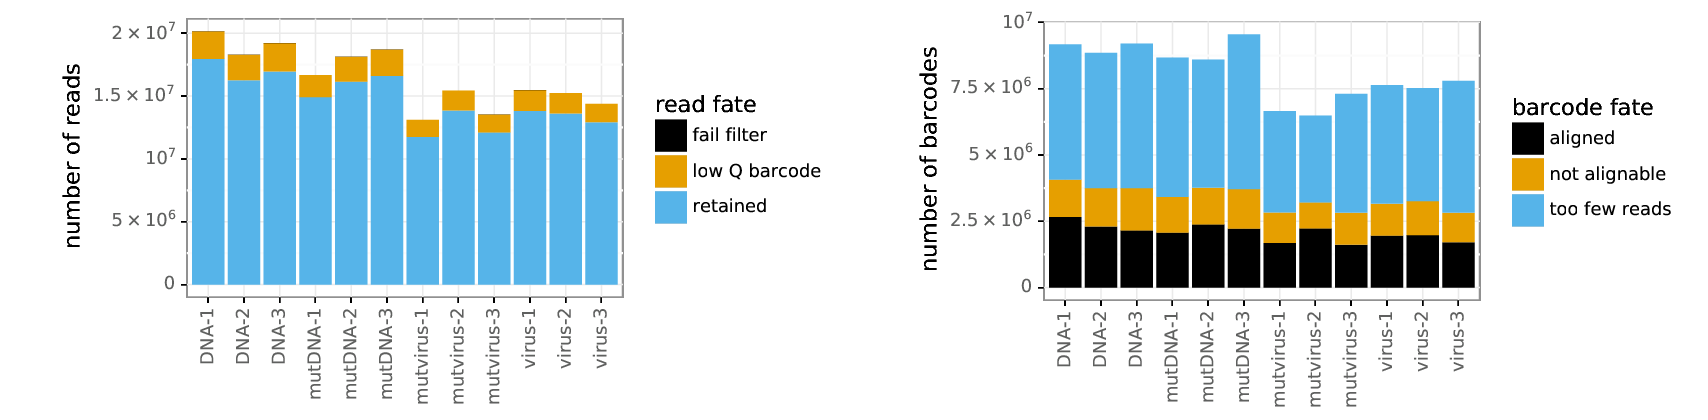

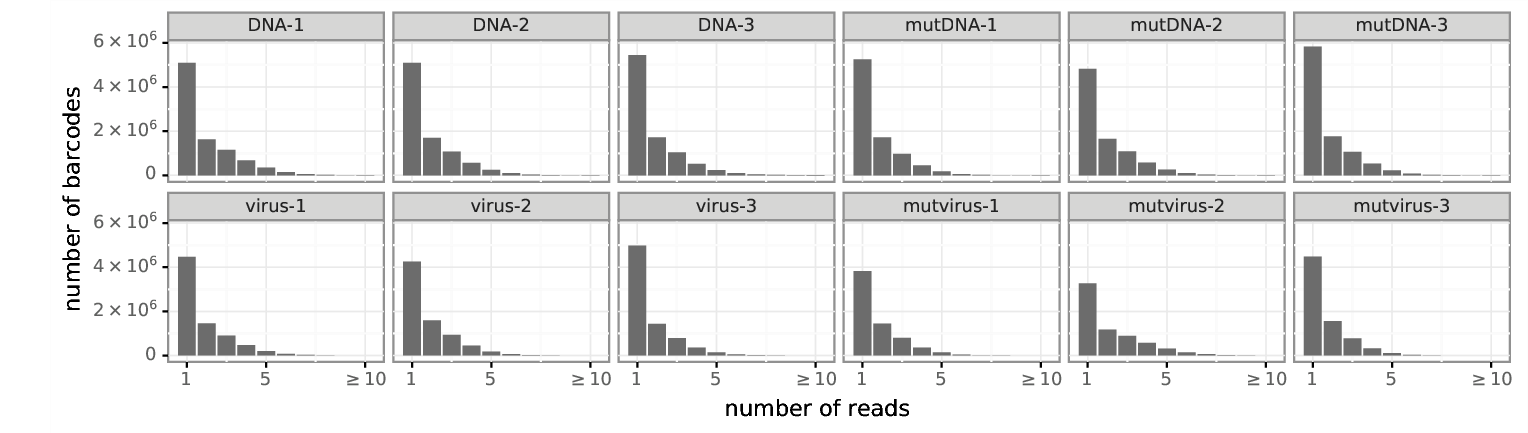


Read and barcode stats for BF520:


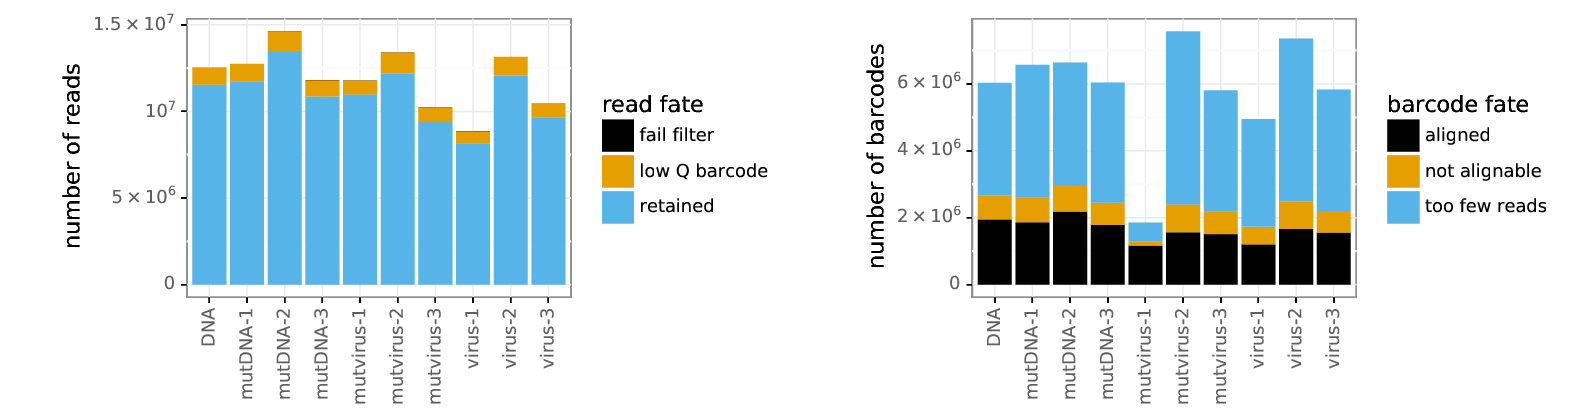

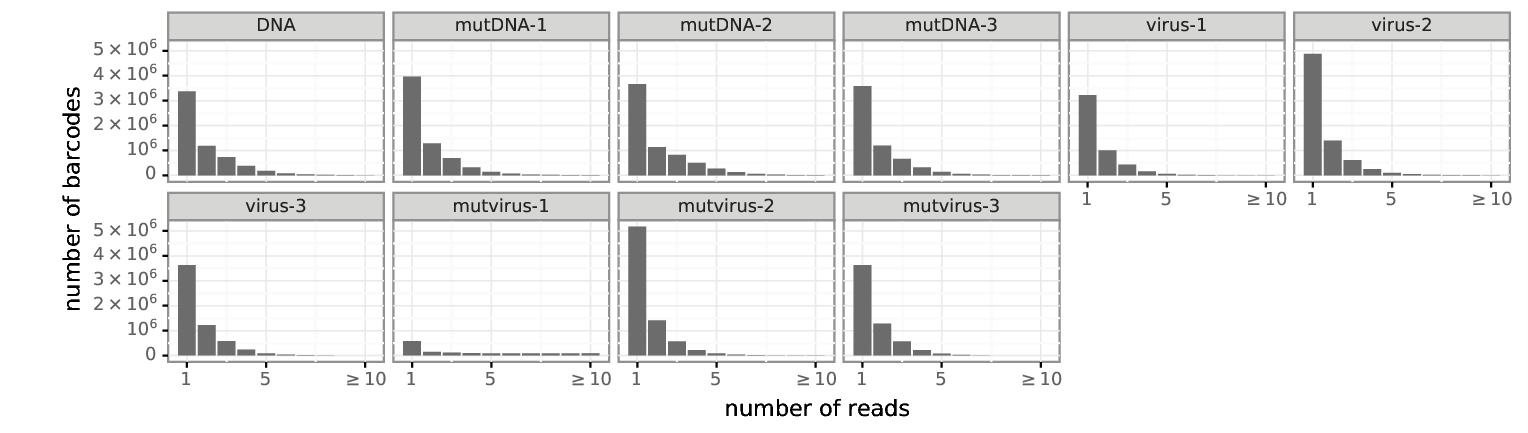

In [8]:
for env in homologs:
    print("\nRead and barcode stats for {0}:".format(env))
    showPDF([countsplotprefix[env] + suffix for suffix in 
            ['readstats.pdf', 'bcstats.pdf']])
    showPDF(countsplotprefix[env] + 'readsperbc.pdf')

#### Sequencing depth and mutation frequencies across sequence
Now let's look at the sequencing depth and mutation frequencies across the mutagenized regions of the genes for both homologs.
These seem mostly OK.
Most sites in most samples are sequenced to $>2\times 10^5$ codon counts, with only a few subamplicons dipping below this.
The mutation frequencies generally are pretty uniform for the wildtype controls with the exception of a few spikes for the BF520 wildtype *virus* samples.


Depth and mutation frequency across sequence for BG505:


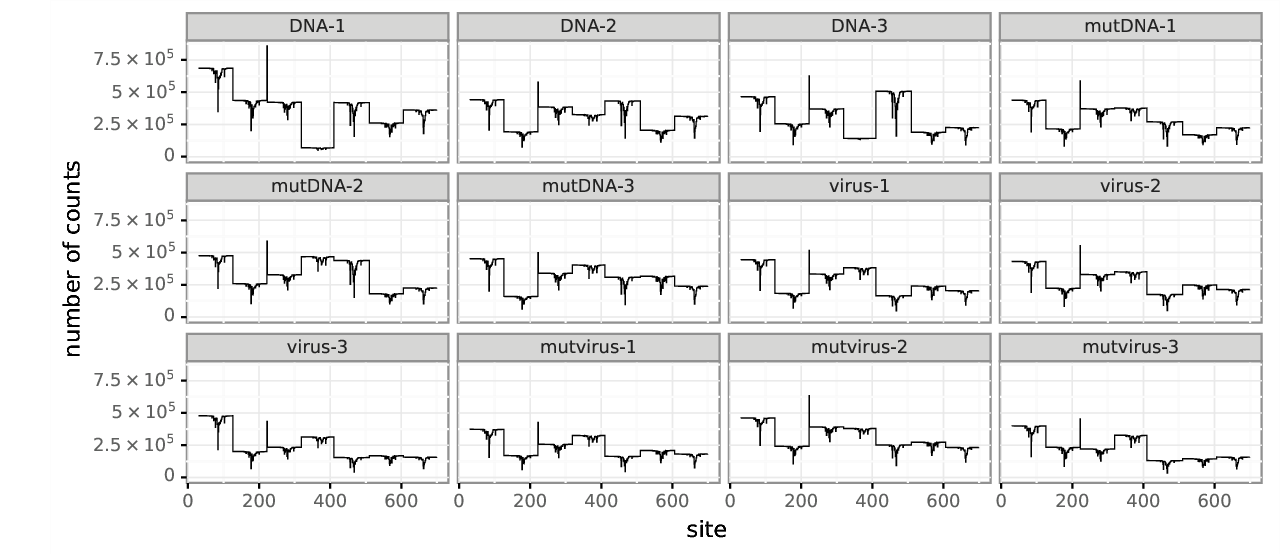

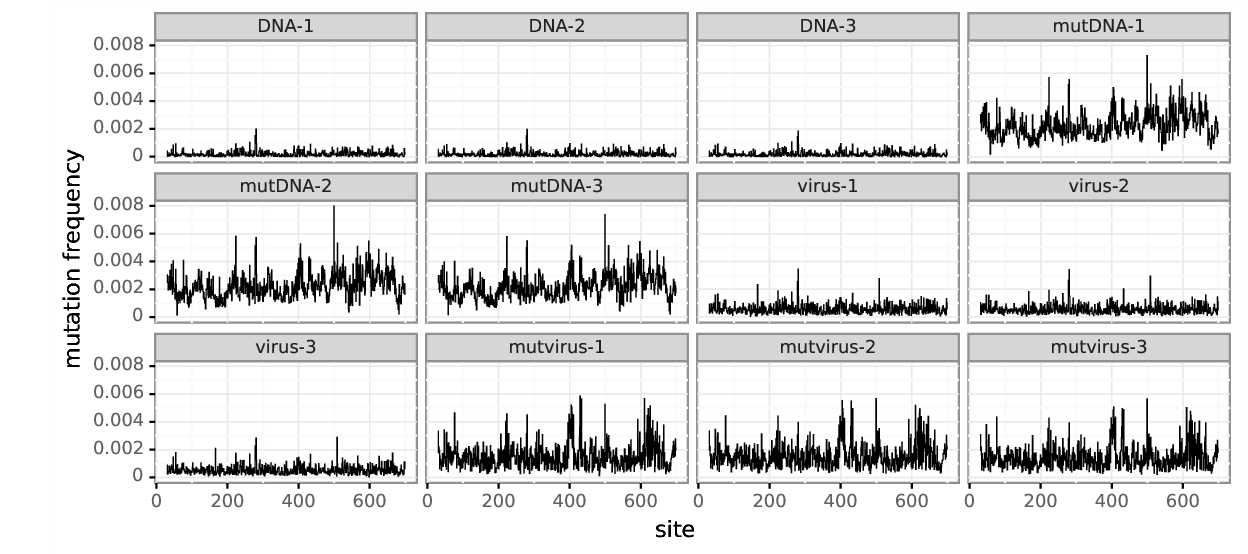


Depth and mutation frequency across sequence for BF520:


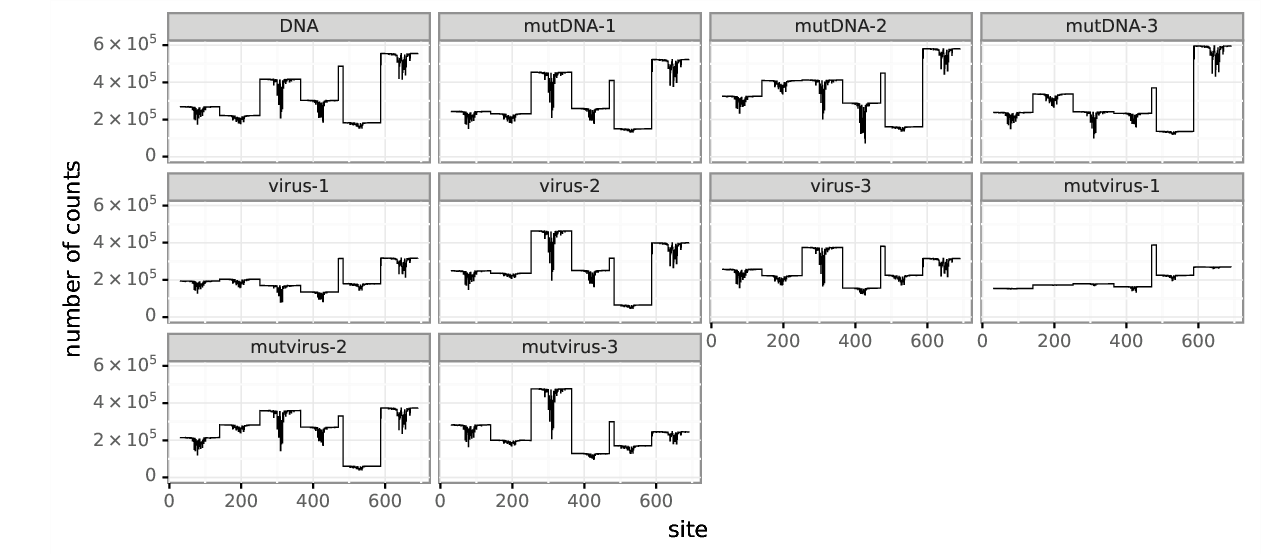

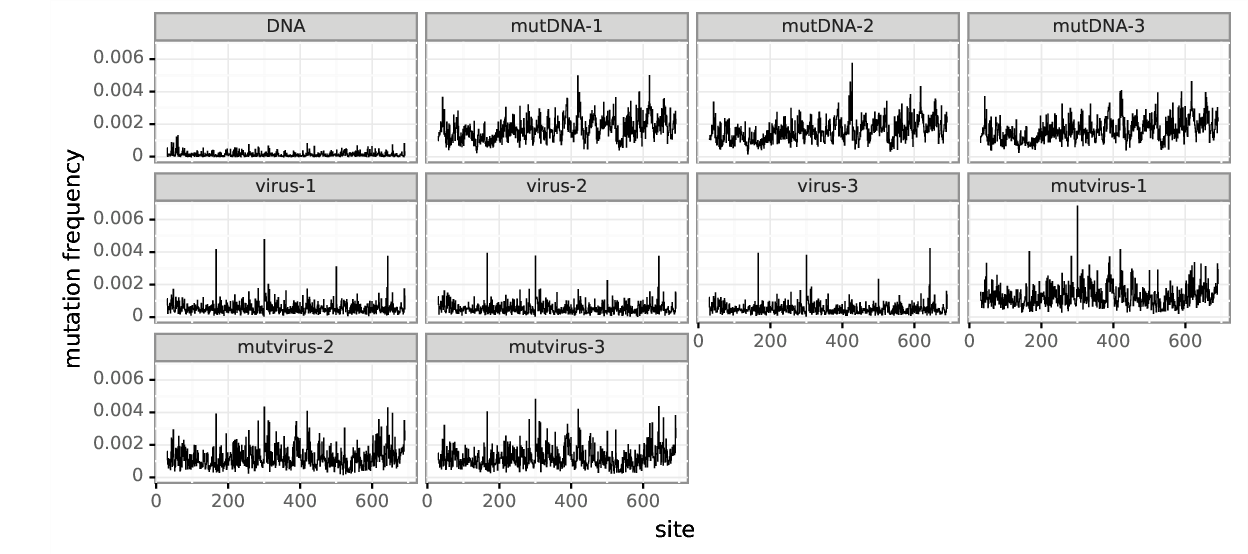

In [9]:
for env in homologs:
    print("\nDepth and mutation frequency across sequence for {0}:".format(env))
    showPDF(countsplotprefix[env] + 'depth.pdf')
    showPDF(countsplotprefix[env] + 'mutfreq.pdf')

#### Average mutation frequencies
Now let's look at the **average** mutation frequencies across sites for each homolog.
In addition to looking at the plots, we also print out a dataframe with the average mutation rates.
Overall, these look quite good -- we see the expected purifying selection in the *mutvirus* samples:


Average mutation frequencies for BG505:


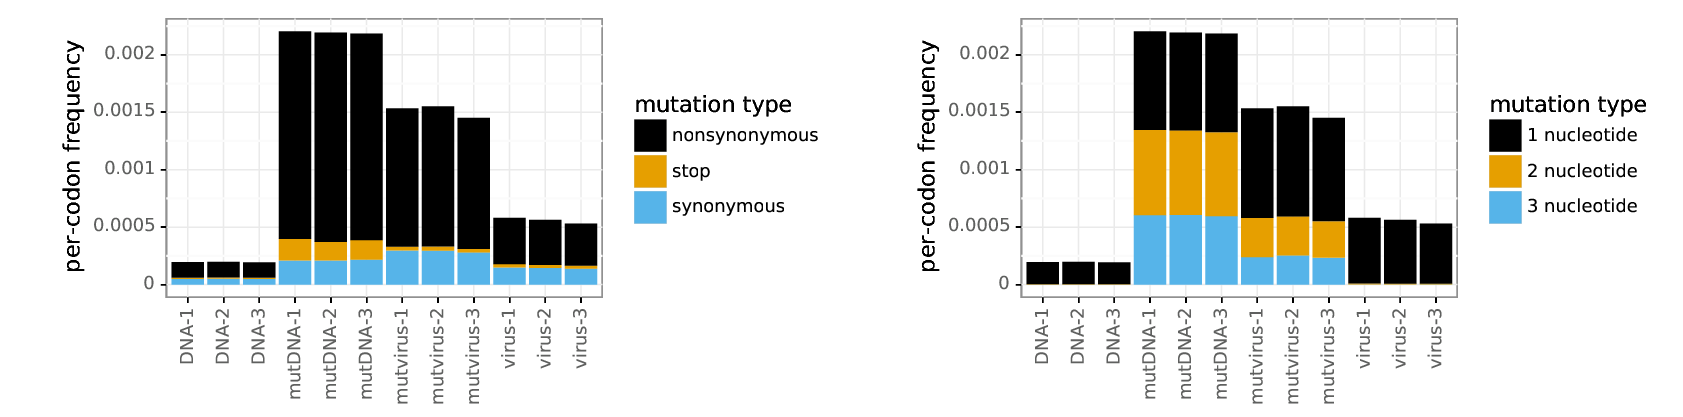


Average mutation frequencies for BF520:


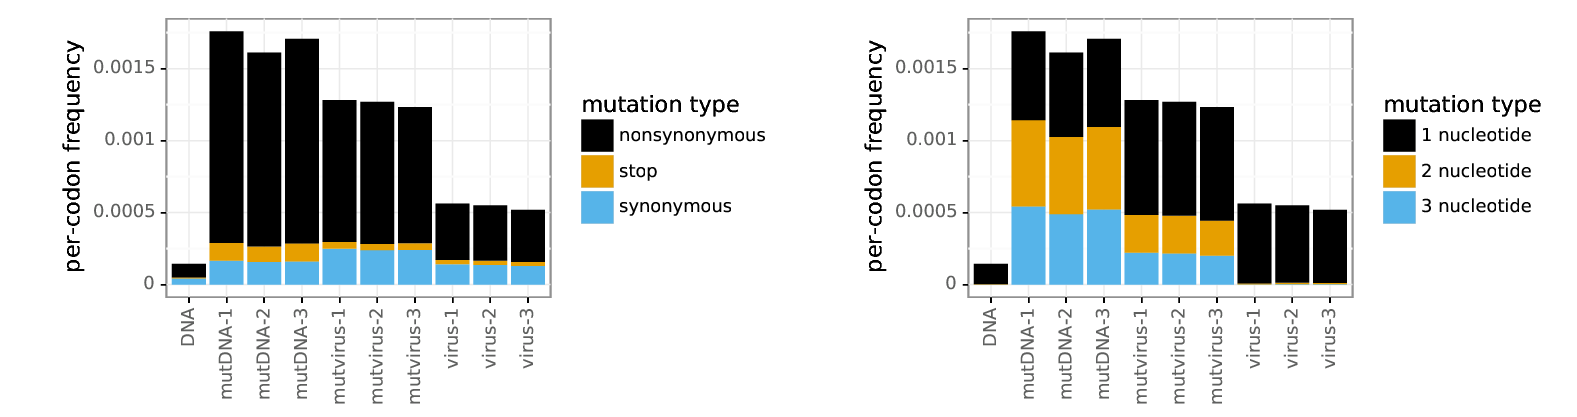

In [10]:
for env in homologs:
    print("\nAverage mutation frequencies for {0}:".format(env))
    showPDF([countsplotprefix[env] + suffix for suffix in 
            ['codonmuttypes.pdf', 'codonntchanges.pdf']])

In [11]:
mutfreqs = pandas.concat([
        pandas.read_csv(countsplotprefix[env] + 'codonmuttypes.csv')
              .assign(homolog=env)
        for env in homologs])
display(HTML(mutfreqs.to_html(index=False)))

homolog,name,nonsynonymous,stop,synonymous
BG505,DNA-1,0.000137,0.000010,0.000049
BG505,DNA-2,0.000137,0.000011,0.000050
BG505,DNA-3,0.000134,0.000010,0.000050
BG505,mutDNA-1,0.001806,0.000188,0.000210
BG505,mutDNA-2,0.001821,0.000162,0.000209
BG505,mutDNA-3,0.001798,0.000170,0.000217
BG505,mutvirus-1,0.001205,0.000034,0.000296
BG505,mutvirus-2,0.001221,0.000036,0.000296
BG505,mutvirus-3,0.001141,0.000030,0.000280
BG505,virus-1,0.000402,0.000029,0.000149


#### Completenes of mutation sampling
Next we look at cumulative fraction plots telling us how completely the different possible mutations were sampled.
We can see that almost all amino-acid mutations were sampled for both homologs in **each** of the triplicate mutant libraries.


Mutation sampling completeness for BG505:


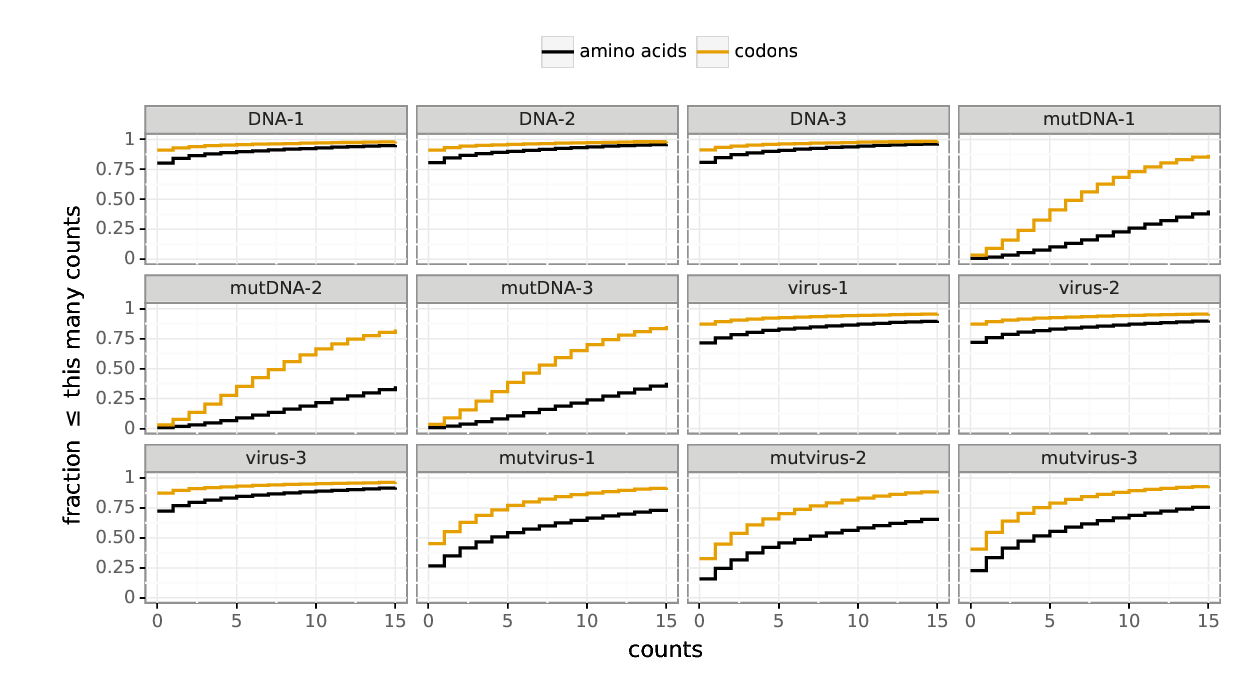


Mutation sampling completeness for BF520:


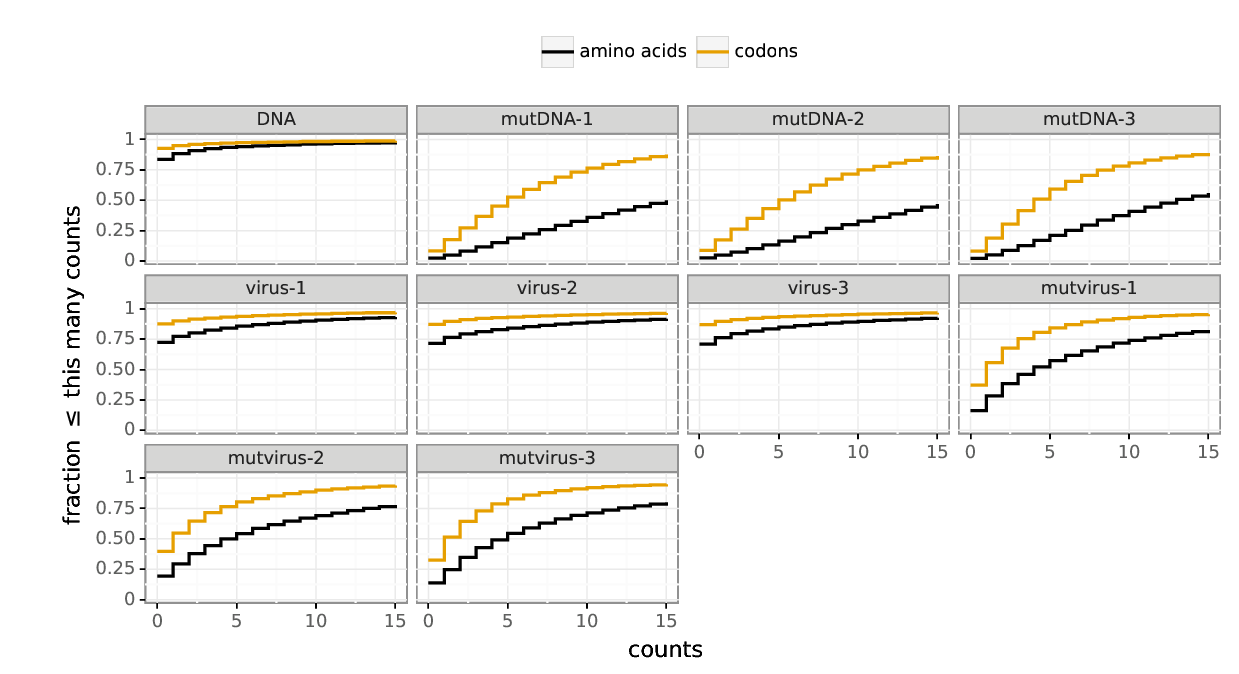

In [12]:
for env in homologs:
    print("\nMutation sampling completeness for {0}:".format(env))
    showPDF(countsplotprefix[env] + 'cumulmutcounts.pdf')

#### Check for oxidative damage
Oxidative damage is characterized by an excess of `C -> A` or `G -> T` mutations.
We see now evidence of an excess of such mutations.
Instead, as expected, the most common mutations are transitions (`G <-> A` or `C <-> T`).


Single-nucleotide change types for BG505:


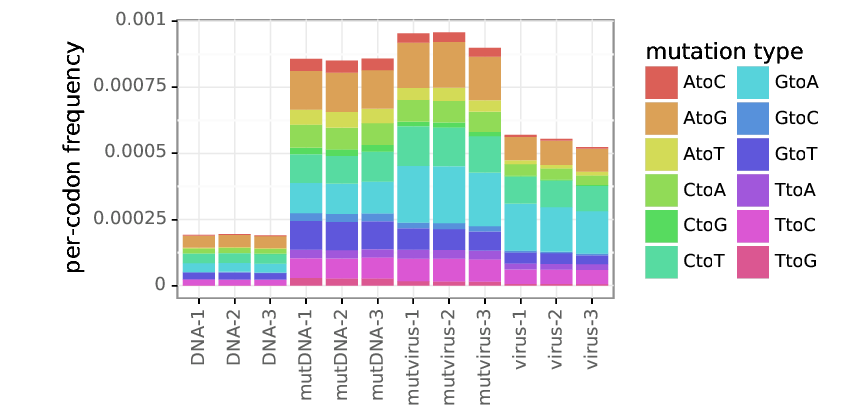


Single-nucleotide change types for BF520:


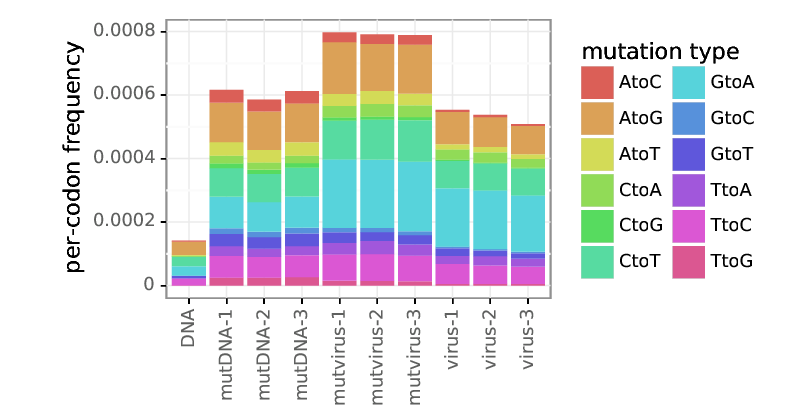

In [13]:
for env in homologs:
    print("\nSingle-nucleotide change types for {0}:".format(env))
    showPDF(countsplotprefix[env] + 'singlentchanges.pdf', width=500)

## Re-number to HXB2 numbering
As mentioned above, we want to perform **all subsequent steps** using sites numbered in the [HXB2 numbering scheme](https://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).
We have already defined renumbering files above to enable this.

Here we create a new results subdirectory that has the re-numbered codon counts for each homolog:

In [14]:
baserenumbcountsdir = os.path.join(resultsdir, 'renumbered_codoncounts')
if not os.path.isdir(baserenumbcountsdir):
    os.mkdir(baserenumbcountsdir)

renumbcountsdir = {}
for env in homologs:
    renumbcountsdir[env] = os.path.join(baserenumbcountsdir, env)
    print("Renumber counts for {0} will go in {1}".format(
            env, renumbcountsdir[env]))
    if not os.path.isdir(renumbcountsdir[env]):
        os.mkdir(renumbcountsdir[env])
    dms_tools2.utils.renumberSites(
            renumbfile[env],
            list(glob.glob(os.path.join(countsdir[env], '*codoncounts.csv'))),
            missing='drop',
            outdir=renumbcountsdir[env]
            )

Renumber counts for BG505 will go in ./results/renumbered_codoncounts/BG505
Renumber counts for BF520 will go in ./results/renumbered_codoncounts/BF520


## Amino-acid preferences 
We now want to use the counts to estimate the [amino-acid preferences](https://jbloomlab.github.io/dms_tools2/prefs.html) for each homolog.

### Estimate the amino-acid preferences
We do this using the program [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html).

In [15]:
prefsdir = os.path.join(resultsdir, 'prefs')
if not os.path.isdir(prefsdir):
    os.mkdir(prefsdir)

# batch file skeleton for dms2_batch_prefs
prefsbatch = pandas.DataFrame(
        columns=['name', 'pre', 'post', 'errpre', 'errpost'],
        data=[('1', 'mutDNA-1', 'mutvirus-1', 'DNA-1', 'virus-1'),
              ('2', 'mutDNA-2', 'mutvirus-2', 'DNA-2', 'virus-2'),
              ('3', 'mutDNA-3', 'mutvirus-3', 'DNA-3', 'virus-3')]
        )

prefsfiles = {} # holds names of the preferences files 
for env in homologs:
    print('\nInferring amino-acid preferences for {0}'.format(env))
    
    envprefsbatch = prefsbatch.copy()
    envprefsbatch['name'] = env + '-' + envprefsbatch['name']
    if env == 'BF520':
        # only one DNA control for this sample
        envprefsbatch['errpre'] = 'DNA'
    print("Here is the batch file for dms2_batch_prefs:")
    display(HTML(envprefsbatch.to_html(index=False)))
    prefsbatchfile = os.path.join(prefsdir, '{0}_batch.csv'.format(env))
    envprefsbatch.to_csv(prefsbatchfile, index=False)
    
    print("Running dms2_batch_prefs...")
    log = !dms2_batch_prefs \
            --indir {renumbcountsdir[env]} \
            --batchfile {prefsbatchfile} \
            --outdir {prefsdir} \
            --summaryprefix {env} \
            --use_existing {use_existing} 
    print("Completed running dms2_batch_prefs")
    
    for name in envprefsbatch.name:
        prefsfiles[name] = os.path.join(prefsdir, name + '_prefs.csv')
    prefsfiles[env + '-avg'] = os.path.join(prefsdir, env + '_avgprefs.csv')


Inferring amino-acid preferences for BG505
Here is the batch file for dms2_batch_prefs:


name,pre,post,errpre,errpost
BG505-1,mutDNA-1,mutvirus-1,DNA-1,virus-1
BG505-2,mutDNA-2,mutvirus-2,DNA-2,virus-2
BG505-3,mutDNA-3,mutvirus-3,DNA-3,virus-3


Running dms2_batch_prefs...
Completed running dms2_batch_prefs

Inferring amino-acid preferences for BF520
Here is the batch file for dms2_batch_prefs:


name,pre,post,errpre,errpost
BF520-1,mutDNA-1,mutvirus-1,DNA,virus-1
BF520-2,mutDNA-2,mutvirus-2,DNA,virus-2
BF520-3,mutDNA-3,mutvirus-3,DNA,virus-3


Running dms2_batch_prefs...
Completed running dms2_batch_prefs


The preferences are now in the following files (one for each replicate plus one with the average for each homolog).
We do not visually display these in logo plots right now; we will wait to do that until after we have re-scaled them to match the stringency of selection in nature.

In [16]:
print("The preferences are in the following files:\n{0}"
        .format('\n'.join(sorted(prefsfiles.values()))))
assert all(map(os.path.isfile, prefsfiles.values()))

The preferences are in the following files:
./results/prefs/BF520-1_prefs.csv
./results/prefs/BF520-2_prefs.csv
./results/prefs/BF520-3_prefs.csv
./results/prefs/BF520_avgprefs.csv
./results/prefs/BG505-1_prefs.csv
./results/prefs/BG505-2_prefs.csv
./results/prefs/BG505-3_prefs.csv
./results/prefs/BG505_avgprefs.csv


### Look at the correlations among replicates
Now we look at the correlations of the inferred amino-acid preferences among replicates for each homolog.
The correlations are pretty good, much better than in our original HIV deep mutational scanning of the LAI strain described in [Haddox et al (2016)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006114).
These improvements may be due to some combination of using different viral strains and various improvements to the deep mutational scanning protocol.
In any case, these improvements are why we will **not** also compare to the old LAI data -- the current data are just much cleaner.

Here are plots showing the correlations between pairs of replicates:


Correlation among preferences for BG505:


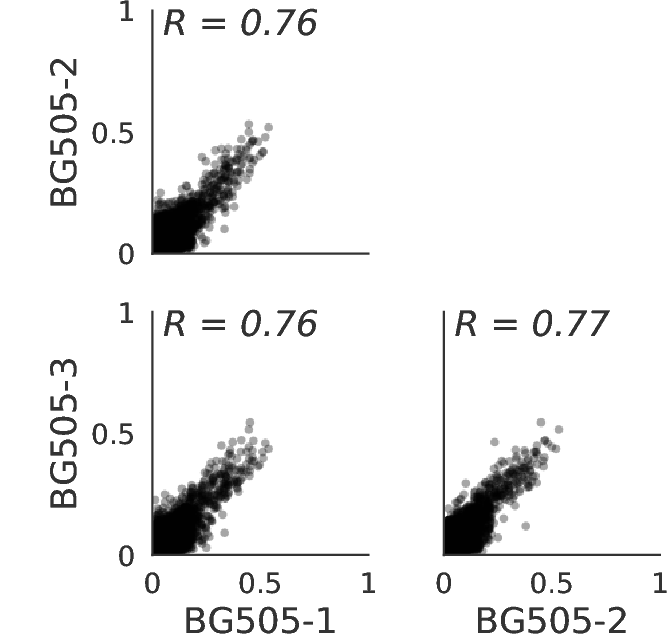


Correlation among preferences for BF520:


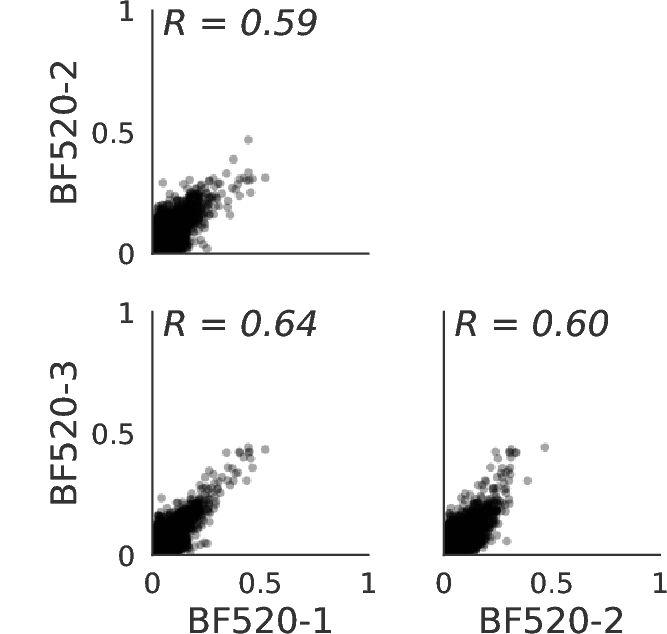

In [17]:
for env in homologs:
    print("\nCorrelation among preferences for {0}:".format(env))
    showPDF(os.path.join(prefsdir, env + '_prefscorr.pdf'), width=300)

## Comparison to HIV evolution in nature

### Curating Env alignment
We curate an alignment of HIV Env coding sequences to use for our phylogenetic analyses.

#### Build clade A alignment 
First we build an alignment of clade A sequences. 
We choose this clade, because that is what our BG505 and BF520 homologs belong to.

1. We start with an Env coding sequence alignment (group M sequences) downloaded from the [Los Alamos HIV Database](https://www.hiv.lanl.gov/content/sequence/HIV/mainpage.html).
This alignment is in [./data/HIV1_FLT_2016_env_DNA.fasta](./data/HIV1_FLT_2016_env_DNA.fasta).

2. We  extract just the **clade A** sequences from this alignment, removing BG505 and BF520 as we will add them back later. We also keep HXB2 as we need it for numbering conversions.

3. We then use [phydms_prepalignment](http://jbloomlab.github.io/phydms/phydms_prepalignment.html) to curate this alignment down to a reasonable number of sequences by using `--minuniqueness` option.

4. We remove HXB2 (which is clade B), and add the exact BG505 and BF520 sequences used in our deep mutational scanning.

In [18]:
aligndir = os.path.join(resultsdir, 'alignments')
if not os.path.isdir(aligndir):
    os.mkdir(aligndir)

# downloaded alignment with all group M sequences
allgroupM = 'data/HIV1_FLT_2016_env_DNA.fasta'

# get just clade A, also keep HXB2 for alignments and remove later
allcladeA = os.path.join(aligndir, 'cladeA_' + os.path.basename(allgroupM))
Bio.SeqIO.write(
        [s for s in Bio.SeqIO.parse(allgroupM, 'fasta') if 
                s.name[0] == 'A' or 'HXB2' in s.name],
        allcladeA,
        'fasta'
        )

# use phydms_prepalignment to get reasonable number of clean unique seqs
alignmentfile = os.path.join(aligndir, 'cladeA_alignment.fasta')
log = !phydms_prepalignment \
        {allcladeA} \
        {alignmentfile} \
        HXB2 \
        --minuniqueness {160} \
        --prealigned \
        --purgeseqs BG505 BF520
        
# check HXB2 matches sequence used for numbering conversions above
alignment = list(Bio.SeqIO.parse(alignmentfile, 'fasta'))
hxb2aligned = [s for s in alignment if 'HXB2' in s.name]
assert len(hxb2aligned) == 1, "did not find exactly one HXB2 in alignment"
hxb2alignedprot = hxb2aligned[0].seq.translate()
assert hxb2alignedprot == alignedprots['HXB2'].replace('-', ''),\
        "HXB2 in large alignment doesn't match that used for numbering conversions"
    
# get alignment without HXB2 (which is not clade A)
alignment = [s for s in alignment if 'HXB2' not in s.name]

# now add our homologs to alignment, aligning via numbering schemes defined above
for env in homologs:
    seq = str(Bio.SeqIO.read(wtseqfiles[env], 'fasta').seq)
    # get dict mapping 1, 2, ... HXB2 number to 1, 2, ... numbering of homolog
    renumb = (pandas.read_csv(renumbfile[env])
             .convert_objects(convert_numeric=True)
             .dropna()
             .set_index('new')['original']
             .to_dict()
             )
    alignedseq = []
    for r in range(1, len(hxb2alignedprot) + 1):
        if r in renumb:
            r_env = renumb[r] 
            alignedseq.append(seq[3 * (r_env - 1) : 3 * r_env])
        else:
            alignedseq.append('---')
    alignment.append(Bio.SeqRecord.SeqRecord(Bio.Seq.Seq(''.join(alignedseq)), 
            id=env, description=''))
    
Bio.SeqIO.write(alignment, alignmentfile, 'fasta')
print("Alignment of {0} sequences has been written to {1}".format(
        len(alignment), alignmentfile))

Alignment of 75 sequences has been written to ./results/alignments/cladeA_alignment.fasta


/Users/jbloom/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:36: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


#### Mask poorly aligned sites
Some parts of Env align very poorly, particularly in the variable loops.
We therefore mask these sites as improperly aligned sites can confound phylogenetic analyses.

We mask the following sites (selected by Hugh Haddox), all of which are referred to in 1, 2, ... HXB2 numbering.

* sites for which there is no deep mutational scanning data:
    - signal peptide: 1-30
    - cytoplasmic tail: 703-856
* sites in the variable loops V1, V2, V4, and V5 that, by eye, look like low-confidence regions due to many indels:
    * part of V1: 132-151
    * part of V2: 185-190
    * part of V4: 396-413
    * part of V5: 460-465
* sites where >5% of sequences in our clade A alignment have a gap. These sites are computationally determined below.

For the masking, we create a data frame that has the HXB2 number, the corresponding number (if any) for each homolog in HXB2 numbering, and whether or not the site needs to be masked.
We use the same mask for both homologs so that they can all be analyzed in the context of the same alignment.

In [19]:
maskfile = os.path.join(aligndir, 'alignment_mask.csv')

# first create data frame that lists all HXB2 sites
sites = list(range(1, len(hxb2alignedprot) + 1)) # list of all sites in HXB2
mask = (pandas.DataFrame({'HXB2':sites}).set_index('HXB2'))
mask.index = mask.index.astype('str') # handle sites as strings a some have letters

# now add columns for each homolog
for env in homologs:
    env_df = (pandas.read_csv(renumbfile[env])
              .rename(columns={'new':'HXB2', 'original':env})
              .set_index('HXB2')
              )
    env_df.index = env_df.index.astype('str')
    env_df[env] = env_df[env].astype('str')
    mask = mask.join(env_df)

# specify sites to mask
# first, sites specified manually
maskedsites = set([])
for (x, y) in [(1, 30), (703, 856), (132, 151), (185, 190), (396, 413), (460, 465)]:
    maskedsites = maskedsites.union(set(range(x, y + 1))) 
# now sites with too many gaps
maxgapfrac = 0.05
maxgaps = maxgapfrac * len(alignment) 
for r in sites:
    ngaps = sum([s.seq[3 * (r - 1) : 3 * r] == '---' for s in alignment])
    if ngaps > maxgaps:
        maskedsites.add(r)
# now add gapped sites to df
mask['masked'] = [True if r in maskedsites else False for r in sites] 

# add to mask any sites that don't align to HXB2 for any homolog
for env in homologs:
    mask['masked'] = mask[env].isnull() | mask['masked']
    
# unmaskedsites in HXB2 numbering
unmaskedsites = mask[~mask['masked']].index.astype('int')

print("Masked a total of {0} sites".format(sum(mask['masked'])))
print("Writing the alignment mask to {0}".format(maskfile))
mask.to_csv(maskfile)

Masked a total of 240 sites
Writing the alignment mask to ./results/alignments/alignment_mask.csv


#### Build masked alignment
Finally, we need to build an alignment of only the non-masked sites that we can use for subsequent analyses:

In [20]:
maskedalignmentfile = os.path.join(aligndir, 'masked_alignment.fasta')

maskedalignment = []
for s in alignment:
    maskedalignment.append(Bio.SeqRecord.SeqRecord(
            Bio.Seq.Seq(''.join([str(s.seq)[3 * (r - 1) : 3 * r] for r in unmaskedsites])),
            id=s.id,
            description='',
            ))
    
print("The masked alignment consists of {0} sequences each {1} codons long."
        .format(len(maskedalignment), len(unmaskedsites)))
Bio.SeqIO.write(maskedalignment, maskedalignmentfile, 'fasta')
print("Writing this alignment to {0}".format(maskedalignmentfile))

The masked alignment consists of 75 sequences each 616 codons long.
Writing this alignment to ./results/alignments/masked_alignment.fasta


#### Plot amino-acid divergence from each homolog
Now we plot the amino-acid divergence of each sequence in our masked alignment from each homolog.
So these divergences are only considering the non-masked sites.
We count an alignment of a gap to a non-gap character as a difference.

Among masked sites, protein identity of BG505 to BF520 is 0.891 (549 of 616)


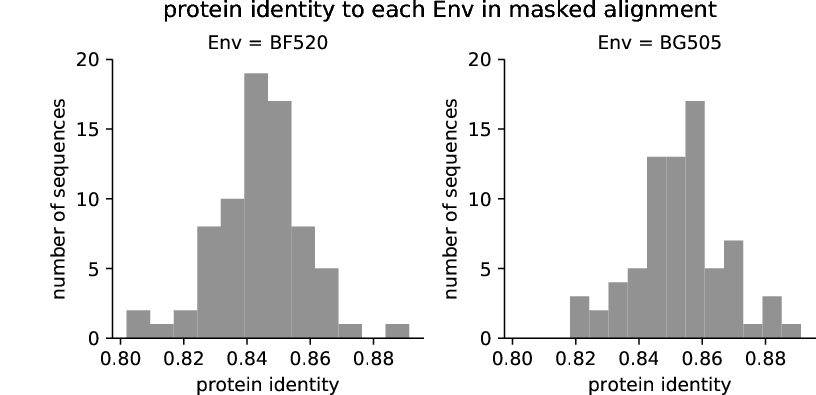

In [21]:
identityplot = os.path.join(aligndir, 'masked_alignment_identity.pdf')

maskedprots = dict([(s.id, s.seq.translate(gap='-')) for s in maskedalignment])

fracidents = dict([(env, []) for env in homologs])
for (i, env) in enumerate(homologs):
    maskedenv = maskedprots[env]
    for (prot_id, prot) in maskedprots.items():
        if prot_id == env:
            continue
        nident = sum([aa == prot[r] for (r, aa) in enumerate(maskedenv)])
        fracident = nident / len(maskedenv)
        fracidents[env].append(fracident)
        if prot_id in homologs[i + 1 :]:
            print("Among masked sites, protein identity of {0} to {1} is "
                "{2:.3f} ({3} of {4})".format(env, prot_id,
                fracident, nident, len(maskedenv)))
fracidents_df = (pandas.DataFrame(fracidents)
                 .melt(var_name='Env', value_name='protein identity')
                 )

p = seaborn.FacetGrid(fracidents_df, col='Env')
(p.map(plt.hist, 'protein identity', color='gray', bins=12)
        .set(ylabel='number of sequences'))
p.fig.suptitle('protein identity to each Env in masked alignment',
        verticalalignment='bottom')
p.savefig(identityplot)
showPDF(identityplot, width=500)

###  Phylogenetic analysis
Now we run [phydms](http://jbloomlab.github.io/phydms/) for each homolog.
This analysis allows us to compare an experimentally informed codon model (*ExpCM*) to traditional Goldman-Yang (denoted *YNGKP* here) models.
It also allows us to identify sites evolving faster or slower in nature than expected from the experiments.

First we create a directory for this analysis:

In [22]:
phydmsdir = os.path.join(resultsdir, 'phydms_analysis/')
if not os.path.isdir(phydmsdir):
    os.mkdir(phydmsdir)

#### Create masked preference sets
We will create an *ExpCM* with the **average** preferences among replicates for each homolog. 
The preferences we have estimated above are in HXB2 numbering for all sites.
The [phydms](http://jbloomlab.github.io/phydms/) analyses require the alignment sites and preferences to both be in 1, 2, ... numbering.
Because we have only retained some sites after creating our masked alignment, we need to create preferences that sequentially number these masked sites.

In [23]:
maskedavgprefs = [os.path.join(phydmsdir, env + '.csv') 
        for env in homologs]

renumb_hxb2_to_mask = os.path.join(phydmsdir, 'renumb_hxb2_to_mask.csv')
(pandas.DataFrame({'original':unmaskedsites, 
                   'new':list(range(1, len(unmaskedsites) + 1))})
        .to_csv(renumb_hxb2_to_mask, index=False)
        )

dms_tools2.utils.renumberSites(
        renumbfile=renumb_hxb2_to_mask,
        infiles=[prefsfiles[env + '-avg'] for env in homologs],
        missing='drop',
        outfiles=maskedavgprefs
        )

#### Run `phydms`
Now we run [phydms_comprehensive](http://jbloomlab.github.io/phydms/phydms_comprehensive_prog.html).
Note that this requires that [RAxML](https://sco.h-its.org/exelixis/web/software/raxml/index.html) is installed at the path specified by `--raxml`.

In [24]:
modelcomparefile = os.path.join(phydmsdir, 'modelcomparison.md')

if (use_existing != 'yes') or (not os.path.isfile(modelcomparefile)):
    log = !phydms_comprehensive \
            {phydmsdir}/ \
            {maskedalignmentfile} \
            {' '.join(maskedavgprefs)} \
            --raxml raxml \
            --ncpus {ncpus} \
            --gammaomega \
            --omegabysite

^C


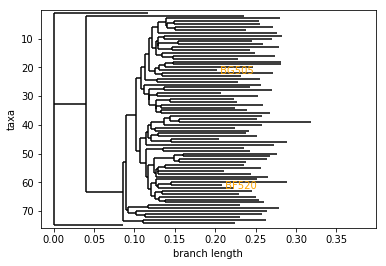

In [30]:
treefile = os.path.join(phydmsdir, 'RAxML_tree.newick')
tree = Bio.Phylo.read(treefile, 'newick')
Bio.Phylo.draw(tree,
        label_func=lambda x: str(x) if str(x) in homologs else '',
        label_colors=dict([(env, 'orange') for env in homologs])
        )